<a href="https://colab.research.google.com/github/vi14m/Sign_Language_Recognition_DeepLearning/blob/main/Sign_Language_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data  sign_mnist_test.csv  sign_mnist_train.csv


In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [11]:
# Load data from CSV
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

In [12]:
# Rename label to Label for consistency
train_df.rename(columns={'label': 'Label'}, inplace=True)
test_df.rename(columns={'label': 'Label'}, inplace=True)

# Shuffle the datasets
train_df = train_df.sample(frac=1.0).reset_index(drop=True)
test_df = test_df.sample(frac=1.0).reset_index(drop=True)

In [13]:
# Create a mapping from label numbers to letters
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {i: l.upper() for i, l in enumerate(alphab) if l not in ['j', 'z']}  # Skip 'j' and 'z'

print("Mapping of Labels to Letters:")
print(mapping_letter)

Mapping of Labels to Letters:
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}


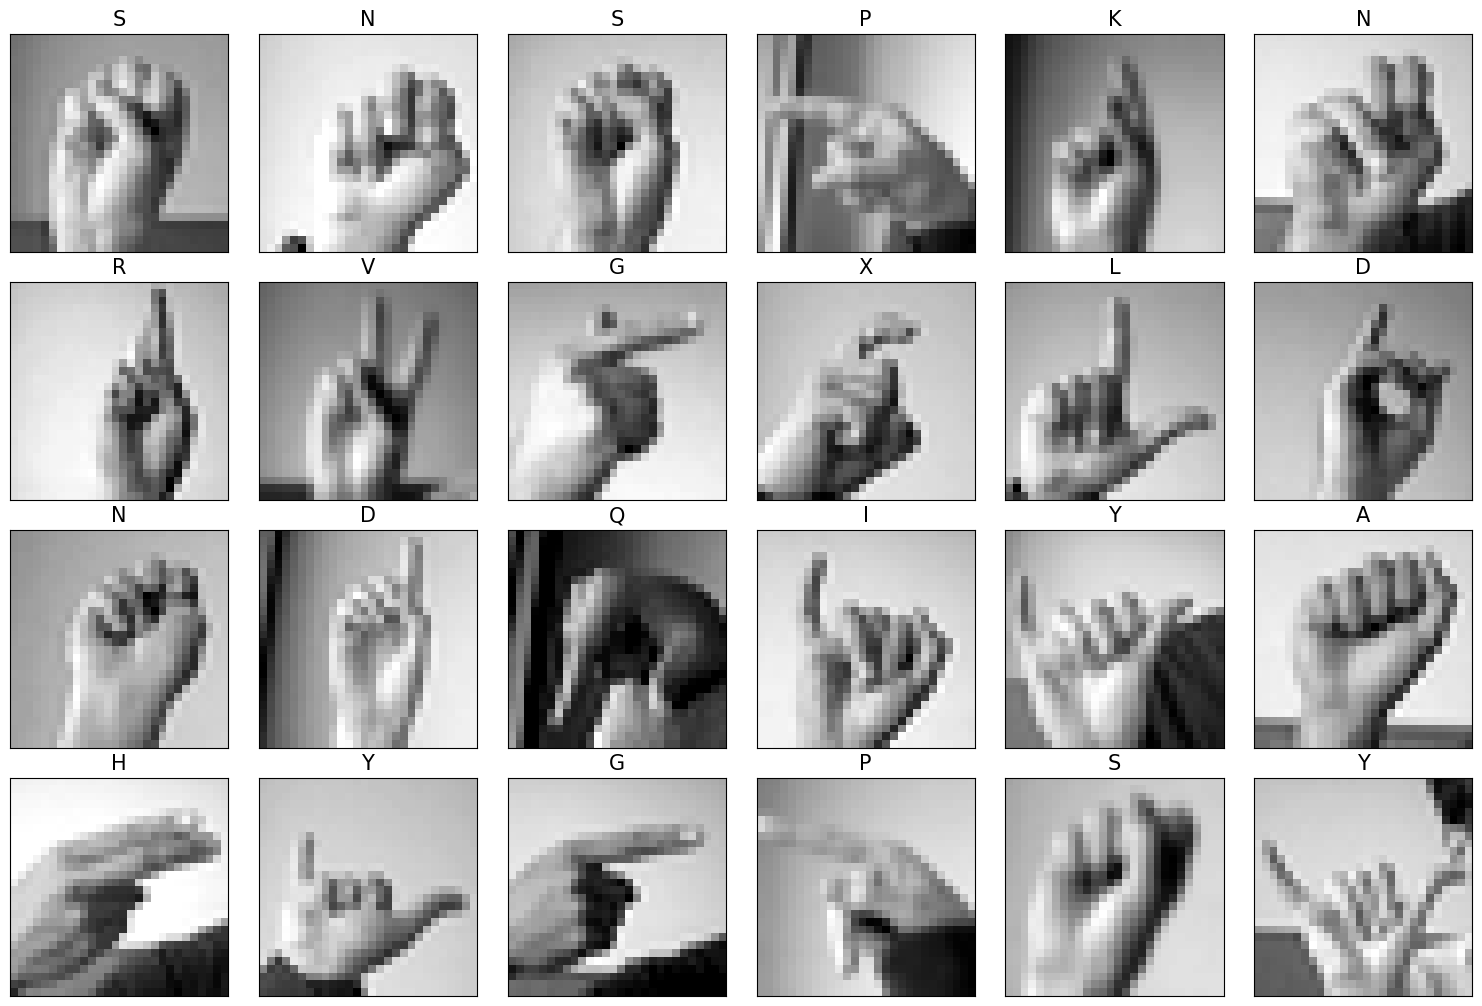

In [14]:
# Function to convert flattened pixel data into an image
def to_image(row):
    img = row.drop('Label').values.reshape(28, 28).astype(np.uint8)
    return img

# Display some pictures of the dataset with their corresponding labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img = to_image(train_df.iloc[i])
    ax.imshow(img, cmap='gray')
    title = mapping_letter.get(train_df.Label[i], "Unknown")
    ax.set_title(title, fontsize=15)

plt.tight_layout(pad=0.5)
plt.show()

<ipython-input-15-d7375993ba86>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted(vc.index), y=vc, palette="rocket")


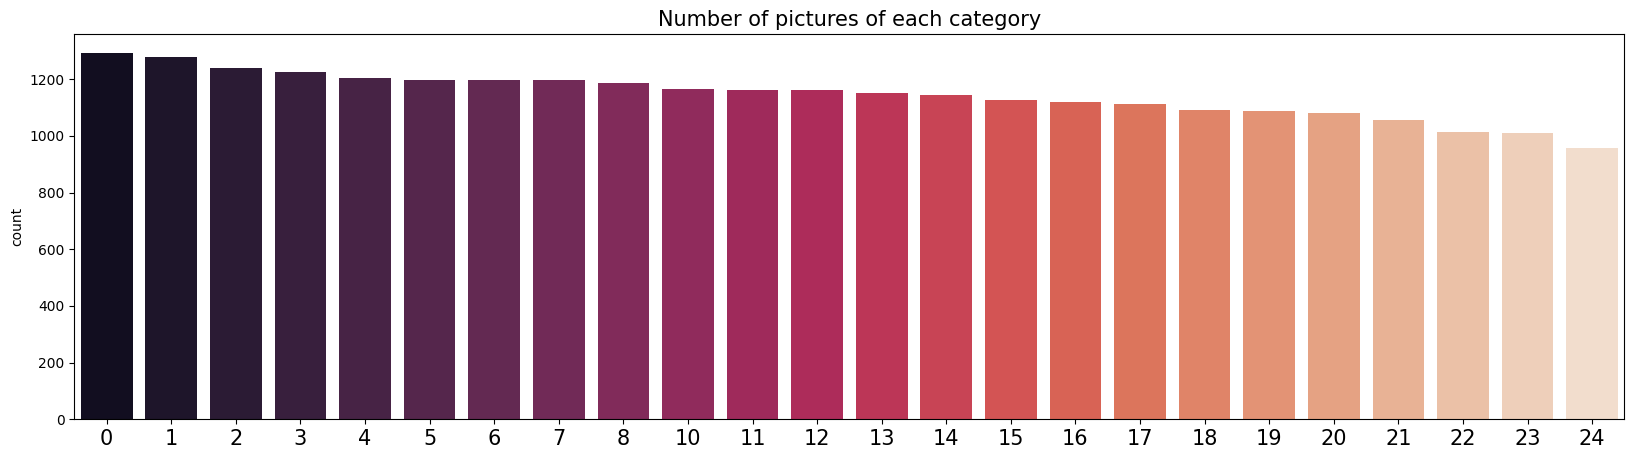

In [15]:
# Display the number of pictures for each letter
vc = train_df['Label'].value_counts()
plt.figure(figsize=(20, 5))
sns.barplot(x=sorted(vc.index), y=vc, palette="rocket")
plt.title("Number of pictures of each category", fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [16]:
# Prepare the data for model training
X_train = train_df.drop('Label', axis=1).values
y_train = train_df['Label'].values
X_test = test_df.drop('Label', axis=1).values
y_test = test_df['Label'].values

# Reshape pixel values to images
IMG_SIZE = (28, 28)
X_train = X_train.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
X_test = X_test.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Handle NaNs
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=25)  # 24 classes
y_test = tf.keras.utils.to_categorical(y_test, num_classes=25)

# Verify no NaNs in data
assert not np.isnan(X_train).any(), "NaNs still found in training data!"
assert not np.isnan(y_train).any(), "NaNs still found in training labels!"

In [18]:
# Build the model with the correct number of output classes
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')  # Corrected to 25 classes
])

# Compile the model
optimizer = Adam(learning_rate=1e-4)  # Lowered learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('gesture_recognition_model.h5', save_best_only=True, monitor='val_loss')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Ensure no NaNs in data
assert not np.isnan(X_train).any(), "NaNs found in training data!"
assert not np.isnan(y_train).any(), "NaNs found in training labels!"

# Train the model
model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Optionally save the model after training is complete
model.save('gesture_recognition_model_final.h5')


Epoch 1/30
858/858 [==============================] - 16s 17ms/step - loss: 2.4758 - accuracy: 0.2880 - val_loss: 1.3102 - val_accuracy: 0.6559
Epoch 2/30
  5/858 [..............................] - ETA: 12s - loss: 1.6086 - accuracy: 0.5063

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


858/858 [==============================] - 14s 17ms/step - loss: 1.3672 - accuracy: 0.5682 - val_loss: 0.6455 - val_accuracy: 0.7945
Epoch 3/30
858/858 [==============================] - 14s 16ms/step - loss: 0.9358 - accuracy: 0.6959 - val_loss: 0.3701 - val_accuracy: 0.8812
Epoch 4/30
858/858 [==============================] - 14s 16ms/step - loss: 0.6746 - accuracy: 0.7793 - val_loss: 0.2201 - val_accuracy: 0.9335
Epoch 5/30
858/858 [==============================] - 14s 16ms/step - loss: 0.5195 - accuracy: 0.8306 - val_loss: 0.1794 - val_accuracy: 0.9504
Epoch 6/30
858/858 [==============================] - 14s 16ms/step - loss: 0.4140 - accuracy: 0.8653 - val_loss: 0.1413 - val_accuracy: 0.9594
Epoch 7/30
858/858 [==============================] - 14s 16ms/step - loss: 0.3341 - accuracy: 0.8904 - val_loss: 0.1370 - val_accuracy: 0.9571
Epoch 8/30
858/858 [==============================] - 14s 16ms/step - loss: 0.2767 - accuracy: 0.9093 - val_loss: 0.0770 - val_accuracy: 0.9785
Epo

1/1 [==============================] - 0s 128ms/step


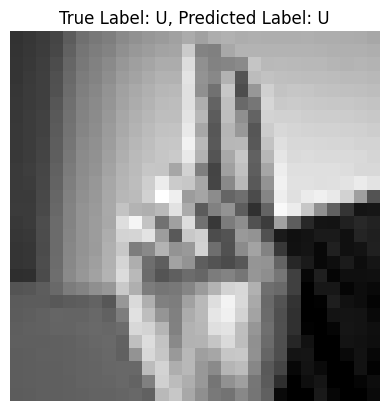

In [19]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model('gesture_recognition_model.h5')

# Choose a random test sample
random_index = np.random.randint(0, X_test.shape[0])
sample_image = X_test[random_index]
true_label = np.argmax(y_test[random_index])

# Make a prediction
prediction = loaded_model.predict(np.expand_dims(sample_image, axis=0))
predicted_label = np.argmax(prediction)

# Display the result
plt.imshow(sample_image.reshape(IMG_SIZE[0], IMG_SIZE[1]), cmap='gray')
plt.title(f"True Label: {mapping_letter.get(true_label, 'Unknown')}, Predicted Label: {mapping_letter.get(predicted_label, 'Unknown')}")
plt.axis('off')
plt.show()
